# MOS score prediction from wav2vec2 embeddings

* calculate wav2vec2 embeddings for test and train datasets
* create MOSDataset, containing wav2vec2 embeddings and subjective MOS scores
* define a simple neural network to predict MOS scores from wav2vec2 embeddings
* train the neural network and save the model
* evaluate the model
* repeat the process for different wav2vec2 models? other embeddings? use embeddings from different layers? need another 8 months to finish this notebook

In [1]:
import os
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# wav2vec
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model, Wav2Vec2Config
import librosa

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


/home/aleph/tesis/.env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# wav2vec2 embeddings extraction

In [2]:
def wav2vec_embeddings(path_to_csv, model_name, output_dir):
    """Extracts embeddings from audio files given a specific Wav2Vec2 model.
    Extracts all layers and stacks them together into a tensor. Then saves that tensor as a numpy array.
    Expects csv file with a column named "stimuli" containing paths to audio files."""

    os.makedirs(output_dir, exist_ok=True)

    config = Wav2Vec2Config.from_pretrained(model_name, output_hidden_states=True)
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
    model = Wav2Vec2Model(config)
    
    #load data
    metadata_df = pd.read_csv(path_to_csv)

    # iterate over each path in "stimuli" column
    for _, row in tqdm(metadata_df.iterrows()):
        audio_file = row['stimuli']
        input_audio, sample_rate = librosa.load(audio_file, sr=16000)
        inputs = feature_extractor(input_audio, return_tensors="pt", sampling_rate=sample_rate)
        
        with torch.no_grad():
            outputs= model(**inputs)
        
        all_layer_embeddings = outputs.hidden_states

        # Concatenate hidden states from all layers and take the mean across the sequence
        # Skip the first layer --> output of the CNN layers with an added positional embedding
        embeddings = torch.cat(all_layer_embeddings[, dim=0)
        embeddings = embeddings.mean(dim=1)

        # Save embeddings as numpy array
        embeddings = embeddings.squeeze().detach().numpy()
        file_name = os.path.basename(audio_file).split('.')[0]

        np.save(os.path.join(output_dir, f"{file_name}.npy"), embeddings)

In [9]:
# extract embeddings for dev set
path_to_dev_csv = '/home/aleph/tesis/classifier/dev.csv'
path_to_dev_embeddings = '/home/aleph/tesis/classifier/embeddings/dev'
# wav2vec_embeddings(path_to_dev_csv, path_to_dev_embeddings)

# extract embeddings for test set
path_to_test_csv = '/home/aleph/tesis/classifier/test.csv'
path_to_test_embeddings = '/home/aleph/tesis/classifier/embeddings/test'
# wav2vec_embeddings(path_to_test_csv, path_to_test_embeddings)

# extract embeddings for train set
path_to_train_csv = '/home/aleph/tesis/classifier/train.csv'
path_to_train_embeddings = '/home/aleph/tesis/classifier/embeddings/train'
# wav2vec_embeddings(path_to_train_csv, path_to_train_embeddings)

OSError: facebook/wav2vec2-base-960h does not appear to have a file named config.json. Checkout 'https://huggingface.co/facebook/wav2vec2-base-960h/tree/main' for available files.

## attempt to plot some sort of distribution of the embeddings

In [12]:
# let's explore the embeddings to see distributions of data
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array
from numpy import float32

# get the embeddings read from the csv
train_embeddings = pd.read_csv(path_to_save_train_embeddings)
test_embeddings = pd.read_csv(path_to_save_test_embeddings)

# get the embeddings
train_embeddings = train_embeddings['embeddings']
test_embeddings = test_embeddings['embeddings']

# convert the strings to lists
train_embeddings = train_embeddings.apply(lambda x: eval(x))
test_embeddings = test_embeddings.apply(lambda x: eval(x))

# convert the lists to numpy arrays
train_embeddings = np.array(train_embeddings.tolist())
test_embeddings = np.array(test_embeddings.tolist())

# get the shape of the embeddings
print(f"Train embeddings shape: {train_embeddings.shape}")
print(f"Test embeddings shape: {test_embeddings.shape}")




Train embeddings shape: (3473, 1, 768)
Test embeddings shape: (863, 1, 768)


In [38]:
import umap.umap_ as umap

#Create a numpy array with the features and project them to 2D using UMAP:
X = np.stack(train_embeddings.squeeze())
print('Projecting to 2D with UMAP')
projector = umap.UMAP()
projected = projector.fit_transform(X)
metadata_df = pd.DataFrame()
metadata_df['X'] = projected[:,0]
metadata_df['Y'] = projected[:,1]

Projecting to 2D with UMAP


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


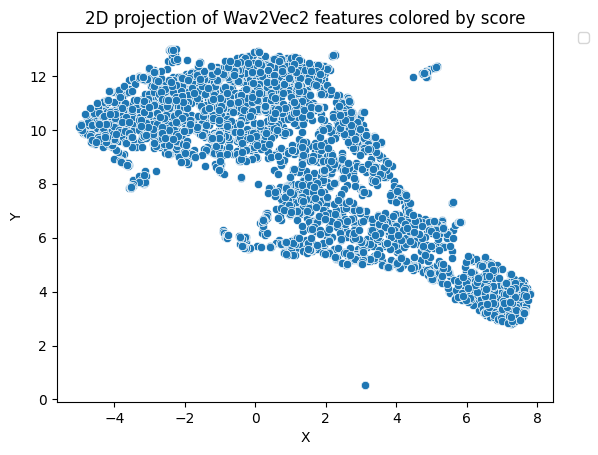

In [40]:
plt.title('2D projection of Wav2Vec2 features colored by score')
sns.scatterplot(data=metadata_df,x='X',y='Y')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

Projecting to 2D with UMAP


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


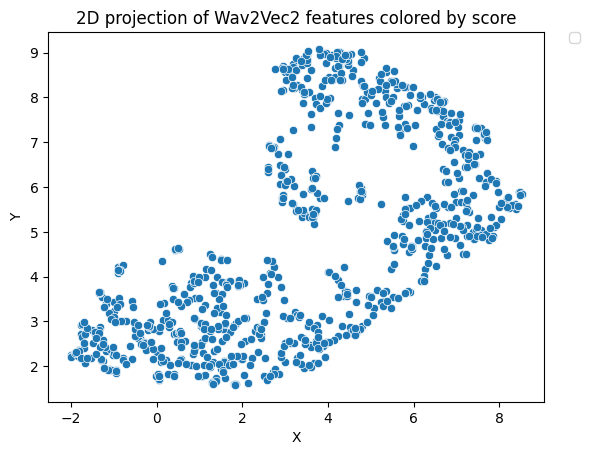

In [41]:
import umap.umap_ as umap

#Create a numpy array with the features and project them to 2D using UMAP:
X = np.stack(test_embeddings.squeeze())
print('Projecting to 2D with UMAP')
projector = umap.UMAP()
projected = projector.fit_transform(X)
metadata_df = pd.DataFrame()
metadata_df['X'] = projected[:,0]
metadata_df['Y'] = projected[:,1]

plt.title('2D projection of Wav2Vec2 features colored by score')
sns.scatterplot(data=metadata_df,x='X',y='Y')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# MOSDataset
* Convert the embeddings from string representations into proper tensors.
* Separate the data into features (embeddings) and targets (MOS scores).

In [2]:
# Custom dataset to read embeddings and MOS scores from a CSV
from numpy import array
from numpy import float32

class MOSDataset(Dataset):
    def __init__(self, csv_file, split):
        # Load the CSV file
        self.data = pd.read_csv(csv_file)
        self.split = "shuffled"  # Store the split (train, val, test)

        
    def __len__(self):
        return len(self.data)  # Total number of samples in the dataset
    
    def __getitem__(self, idx):
        # Get the embeddings and MOS scores for the given index
        file_name = os.path.basename(self.data.iloc[idx]['stimuli'])
        file_folder = os.path.basename(os.path.dirname(self.data.iloc[idx]['stimuli']))

        embeddings_path = f"/home/aleph/tesis/classifier/embeddings/{self.split}/{file_folder}/{file_name.split('.')[0]}.npy"

        # Check if the embeddings file exists
        if not os.path.isfile(embeddings_path):
            raise FileNotFoundError(f"Embeddings file not found at {embeddings_path}")

        embeddings = np.load(embeddings_path)

        mos_score = self.data.iloc[idx]['mos']

        # Convert the numpy array of embeddings to a tensor
        embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32)  # Convert to PyTorch tensor

        # drop first layer
        # embeddings_tensor = embeddings_tensor[1:]
                
        # MOS score should be a single value
        mos_tensor = torch.tensor([mos_score], dtype=torch.float32)  # Convert to tensor
        
        return embeddings_tensor, mos_tensor

# Create the training DataLoader
train_csv_path = "/home/aleph/tesis/classifier/train_shuffled.csv"
train_dataset = MOSDataset(train_csv_path, split='train')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)  # DataLoader with batching and shuffling

# Create the validation DataLoader
val_csv_path = "/home/aleph/tesis/classifier/val_shuffled.csv"
val_dataset = MOSDataset(val_csv_path, split='val')
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Create the testing DataLoader
test_csv_path = "/home/aleph/tesis/classifier/test_shuffled.csv"
test_dataset = MOSDataset(test_csv_path, split='test')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2) 


In [3]:
# Test getting an item
try:
    embeddings, mos = val_dataset[300]  # Test the first item
    print("Embeddings shape:", embeddings.shape)  # Expected shape
    print("MOS score:", mos.item())  # Expected MOS score
except Exception as e:
    print("Error getting item:", e)

Embeddings shape: torch.Size([13, 768])
MOS score: 2.5


In [4]:
#print length of the datasets
print(f"Train dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(val_dataset)}")
print(f"Test dataset length: {len(test_dataset)}")

Train dataset length: 3139
Validation dataset length: 393
Test dataset length: 392


# Neural network

In [5]:
class WeightedAverage(torch.nn.Module):
    def __init__(self, num_layers=12):
        super().__init__()
        self.weights = torch.nn.Parameter(data=torch.ones((num_layers,)))
       
    def forward(self, x):
        w = torch.nn.functional.softmax(self.weights, dim=0)
        x_weighted = x*w[None,:,None]
        return torch.sum(x_weighted, dim=1)

class DenseMOS(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_prob, num_layers):
        super(DenseMOS, self).__init__()

        # add a weighted average layer
        self.weighted_average = WeightedAverage(num_layers)
        
        # First dense layer with 128 neurons, ReLU activation, and dropout
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # Linear layer for dense transformation
            nn.ReLU(),  # ReLU activation
            nn.Dropout(dropout_prob),  # Dropout with 0.2
        )

        # Second dense layer, same design
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
        )

        # Final dense layer for MOS score prediction
        self.output_layer = nn.Linear(hidden_dim, 1)  # Linear layer to predict MOS

    def forward(self, x):
        # Apply the weighted average to combine 12 layers into 1
        x = self.weighted_average(x)  # Apply WeightedAverage

        # Pass the input through the first dense layer
        x = self.layer1(x)

        # Pass through the second dense layer
        x = self.layer2(x)

        # Pass through the final dense layer to get the MOS score
        x = self.output_layer(x)  # Output layer
        
        # min max normalization to 1-5
        x = 1 + (x - x.min()) * 4 / (x.max() - x.min())
        

        return x


# Define the model parameters
input_dim = 768  # Single 768-dimensional input
hidden_dim = 128  # Hidden dimension for dense layers
dropout_prob = 0.6  # Dropout probability
num_layers = 13  # Number of layers in the Wav2Vec2 model

# Training

In [6]:
# Instantiate the DenseMOS model
dense_mos = DenseMOS(input_dim, hidden_dim, dropout_prob, num_layers)
dense_mos.to(device)  # Move the model to the device

DenseMOS(
  (weighted_average): WeightedAverage()
  (layer1): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
  )
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
)

## Define a Loss Function and Optimizer


In [9]:
# define loss and optimizer
loss_fn = nn.MSELoss()  # Mean squared error loss
# propose a different possible loss function
# loss_fn = nn.SmoothL1Loss()  # Huber loss

# Assuming you are using an optimizer like Adam
# optimizer = torch.optim.Adam(dense_mos.parameters(), lr=1e-4, weight_decay=1e-5)  # Add L2 regularization
# optimizer = torch.optim.Adam(dense_mos.parameters(), lr=1e-4)

base_params = [p for name, p in dense_mos.named_parameters() if "weights" not in name]
weight_params = [dense_mos.weighted_average.weights]
optimizer = torch.optim.Adam([
    {'params': base_params},
    {'params': weight_params, 'lr': 1e-3}  # Higher learning rate for weights
], lr=1e-5)

## Training Loop

In [10]:
# Number of epochs and batch size
num_epochs = 1000 # Number of training epochs
batch_size = 32  # Batch size for training

# DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Ensure batch size and shuffle
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # No shuffle for validation

# Track training and validation loss
train_losses = []
val_losses = []

# For early stopping
best_val_loss = float('inf')  # To track the best validation loss
patience = 40  # Patience for early stopping
no_improvement_count = 0  # Counter for epochs without improvement

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Decay LR every 10 epochs

for epoch in range(num_epochs):
    # Training phase with progress bar
    dense_mos.train()  # Set model to training mode
    train_loss = 0.0  # Initialize the training loss
    
    # Use tqdm for progress tracking
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}") as pbar:
        for inputs, targets in train_loader:
            inputs = inputs.to(device)  # Move inputs to the GPU
            targets = targets.to(device)  # Move targets to the GPU

            optimizer.zero_grad()  # Zero out the gradients
            
            outputs = dense_mos(inputs)  # Forward pass
            loss = loss_fn(outputs, targets)  # Compute the loss
            loss.backward()  # Backpropagation
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(dense_mos.parameters(), 1.0)  # Adjust value if needed
            
            optimizer.step()  # Update the weights
            
            train_loss += loss.item()  # Accumulate the loss
            
            pbar.update(1)  # Update the progress bar

    train_loss /= len(train_loader)  # Average loss over all batches
    train_losses.append(train_loss)  # Save the training loss

    # Validation phase
    dense_mos.eval()  # Set model to evaluation mode
    val_loss = 0.0  # Initialize the validation loss

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)  # Move inputs to the GPU
            targets = targets.to(device)  # Move targets to the GPU

            outputs = dense_mos(inputs)  # Forward pass
            loss = loss_fn(outputs, targets)  # Calculate loss
            val_loss += loss.item()  # Accumulate the validation loss

    val_loss /= len(val_loader)  # Average validation loss over all batches
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    # scheduler.step() # Step the scheduler

    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(dense_mos.state_dict(), "best_model.pth")  # Save the best model
        no_improvement_count = 0  # Reset counter
    else:
        no_improvement_count += 1  # Increment counter if no improvement

    # Early stopping check
    if no_improvement_count >= patience:
        print(f"Stopping early after {epoch + 1} epochs due to no improvement in validation loss.")
        break

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the model (optional)
        torch.save(dense_mos.state_dict(), "best_model.pth")

    # Save the model at the end of training
    torch.save(dense_mos.state_dict(), "final_model.pth")

    # print the softmax of the weights of the weighted average layer
    # print(dense_mos.weighted_average.weights)
    # print(torch.nn.functional.softmax(dense_mos.weighted_average.weights, dim=0))
# save train and val losses to csv
losses = pd.DataFrame({'train_loss': train_losses, 'val_loss': val_losses})
losses.to_csv('losses.csv', index=False)

Epoch 1/1000: 100%|██████████| 99/99 [00:01<00:00, 63.30it/s]


Epoch 1/1000, Training Loss: 2.8865, Validation Loss: 2.9988


Epoch 2/1000: 100%|██████████| 99/99 [00:01<00:00, 83.03it/s]


Epoch 2/1000, Training Loss: 2.8466, Validation Loss: 2.5315


Epoch 3/1000: 100%|██████████| 99/99 [00:01<00:00, 81.12it/s]


Epoch 3/1000, Training Loss: 2.8035, Validation Loss: 2.4076


Epoch 4/1000: 100%|██████████| 99/99 [00:01<00:00, 82.76it/s]


Epoch 4/1000, Training Loss: 2.6446, Validation Loss: 2.3109


Epoch 5/1000: 100%|██████████| 99/99 [00:01<00:00, 84.22it/s]


Epoch 5/1000, Training Loss: 2.7476, Validation Loss: 2.2423


Epoch 6/1000: 100%|██████████| 99/99 [00:01<00:00, 81.23it/s]


Epoch 6/1000, Training Loss: 2.6764, Validation Loss: 2.0383


Epoch 7/1000: 100%|██████████| 99/99 [00:01<00:00, 82.88it/s]


Epoch 7/1000, Training Loss: 2.4945, Validation Loss: 1.9120


Epoch 8/1000: 100%|██████████| 99/99 [00:01<00:00, 84.21it/s]


Epoch 8/1000, Training Loss: 2.3786, Validation Loss: 1.9053


Epoch 9/1000: 100%|██████████| 99/99 [00:01<00:00, 82.01it/s]


Epoch 9/1000, Training Loss: 2.4184, Validation Loss: 1.8950


Epoch 10/1000: 100%|██████████| 99/99 [00:01<00:00, 84.48it/s]


Epoch 10/1000, Training Loss: 2.3749, Validation Loss: 1.9013


Epoch 11/1000: 100%|██████████| 99/99 [00:01<00:00, 83.39it/s]


Epoch 11/1000, Training Loss: 2.3517, Validation Loss: 1.9180


Epoch 12/1000: 100%|██████████| 99/99 [00:01<00:00, 82.39it/s]


Epoch 12/1000, Training Loss: 2.2533, Validation Loss: 1.9363


Epoch 13/1000: 100%|██████████| 99/99 [00:01<00:00, 83.63it/s]


Epoch 13/1000, Training Loss: 2.2865, Validation Loss: 1.9342


Epoch 14/1000: 100%|██████████| 99/99 [00:01<00:00, 82.43it/s]


Epoch 14/1000, Training Loss: 2.1801, Validation Loss: 1.9625


Epoch 15/1000: 100%|██████████| 99/99 [00:01<00:00, 80.29it/s]


Epoch 15/1000, Training Loss: 2.2129, Validation Loss: 1.9537


Epoch 16/1000: 100%|██████████| 99/99 [00:01<00:00, 83.19it/s]


Epoch 16/1000, Training Loss: 2.1659, Validation Loss: 1.9103


Epoch 17/1000: 100%|██████████| 99/99 [00:01<00:00, 85.21it/s]


Epoch 17/1000, Training Loss: 2.1371, Validation Loss: 1.8880


Epoch 18/1000: 100%|██████████| 99/99 [00:01<00:00, 80.63it/s]


Epoch 18/1000, Training Loss: 2.1161, Validation Loss: 1.8972


Epoch 19/1000: 100%|██████████| 99/99 [00:01<00:00, 74.00it/s]


Epoch 19/1000, Training Loss: 2.1209, Validation Loss: 2.0050


Epoch 20/1000: 100%|██████████| 99/99 [00:01<00:00, 78.45it/s]


Epoch 20/1000, Training Loss: 2.0870, Validation Loss: 1.9744


Epoch 21/1000: 100%|██████████| 99/99 [00:01<00:00, 80.60it/s]


Epoch 21/1000, Training Loss: 2.0331, Validation Loss: 1.9903


Epoch 22/1000: 100%|██████████| 99/99 [00:01<00:00, 79.34it/s]


Epoch 22/1000, Training Loss: 1.9991, Validation Loss: 1.9306


Epoch 23/1000: 100%|██████████| 99/99 [00:01<00:00, 80.46it/s]


Epoch 23/1000, Training Loss: 2.0189, Validation Loss: 1.9268


Epoch 24/1000: 100%|██████████| 99/99 [00:01<00:00, 86.25it/s]


Epoch 24/1000, Training Loss: 2.0534, Validation Loss: 1.9890


Epoch 25/1000: 100%|██████████| 99/99 [00:01<00:00, 83.29it/s]


Epoch 25/1000, Training Loss: 1.9812, Validation Loss: 1.9927


Epoch 26/1000: 100%|██████████| 99/99 [00:01<00:00, 85.64it/s]


Epoch 26/1000, Training Loss: 1.9737, Validation Loss: 1.9749


Epoch 27/1000: 100%|██████████| 99/99 [00:01<00:00, 85.67it/s]


Epoch 27/1000, Training Loss: 1.9720, Validation Loss: 1.9147


Epoch 28/1000: 100%|██████████| 99/99 [00:01<00:00, 83.71it/s]


Epoch 28/1000, Training Loss: 1.9615, Validation Loss: 1.8306


Epoch 29/1000: 100%|██████████| 99/99 [00:01<00:00, 83.92it/s]


Epoch 29/1000, Training Loss: 1.8995, Validation Loss: 1.8557


Epoch 30/1000: 100%|██████████| 99/99 [00:01<00:00, 80.77it/s]


Epoch 30/1000, Training Loss: 1.8949, Validation Loss: 1.8844


Epoch 31/1000: 100%|██████████| 99/99 [00:01<00:00, 83.32it/s]


Epoch 31/1000, Training Loss: 1.8381, Validation Loss: 1.7867


Epoch 32/1000: 100%|██████████| 99/99 [00:01<00:00, 80.80it/s]


Epoch 32/1000, Training Loss: 1.8817, Validation Loss: 1.7928


Epoch 33/1000: 100%|██████████| 99/99 [00:01<00:00, 85.18it/s]


Epoch 33/1000, Training Loss: 1.8251, Validation Loss: 1.7400


Epoch 34/1000: 100%|██████████| 99/99 [00:01<00:00, 87.19it/s]


Epoch 34/1000, Training Loss: 1.8180, Validation Loss: 1.7845


Epoch 35/1000: 100%|██████████| 99/99 [00:01<00:00, 84.56it/s]


Epoch 35/1000, Training Loss: 1.8650, Validation Loss: 1.7859


Epoch 36/1000: 100%|██████████| 99/99 [00:01<00:00, 81.34it/s]


Epoch 36/1000, Training Loss: 1.8749, Validation Loss: 1.7370


Epoch 37/1000: 100%|██████████| 99/99 [00:01<00:00, 80.14it/s]


Epoch 37/1000, Training Loss: 1.8367, Validation Loss: 1.6833


Epoch 38/1000: 100%|██████████| 99/99 [00:01<00:00, 79.04it/s]


Epoch 38/1000, Training Loss: 1.7874, Validation Loss: 1.6969


Epoch 39/1000: 100%|██████████| 99/99 [00:01<00:00, 83.05it/s]


Epoch 39/1000, Training Loss: 1.8014, Validation Loss: 1.7258


Epoch 40/1000: 100%|██████████| 99/99 [00:01<00:00, 81.49it/s]


Epoch 40/1000, Training Loss: 1.7604, Validation Loss: 1.8309


Epoch 41/1000: 100%|██████████| 99/99 [00:01<00:00, 77.58it/s]


Epoch 41/1000, Training Loss: 1.7636, Validation Loss: 1.7595


Epoch 42/1000: 100%|██████████| 99/99 [00:01<00:00, 83.15it/s]


Epoch 42/1000, Training Loss: 1.7164, Validation Loss: 1.7209


Epoch 43/1000: 100%|██████████| 99/99 [00:01<00:00, 83.05it/s]


Epoch 43/1000, Training Loss: 1.7806, Validation Loss: 1.6925


Epoch 44/1000: 100%|██████████| 99/99 [00:01<00:00, 84.50it/s]


Epoch 44/1000, Training Loss: 1.7206, Validation Loss: 1.7373


Epoch 45/1000: 100%|██████████| 99/99 [00:01<00:00, 79.84it/s]


Epoch 45/1000, Training Loss: 1.7672, Validation Loss: 1.6782


Epoch 46/1000: 100%|██████████| 99/99 [00:01<00:00, 82.24it/s]


Epoch 46/1000, Training Loss: 1.7481, Validation Loss: 1.7008


Epoch 47/1000: 100%|██████████| 99/99 [00:01<00:00, 81.67it/s]


Epoch 47/1000, Training Loss: 1.7306, Validation Loss: 1.6763


Epoch 48/1000: 100%|██████████| 99/99 [00:01<00:00, 82.53it/s]


Epoch 48/1000, Training Loss: 1.6484, Validation Loss: 1.5948


Epoch 49/1000: 100%|██████████| 99/99 [00:01<00:00, 80.93it/s]


Epoch 49/1000, Training Loss: 1.6340, Validation Loss: 1.5923


Epoch 50/1000: 100%|██████████| 99/99 [00:01<00:00, 84.85it/s]


Epoch 50/1000, Training Loss: 1.7256, Validation Loss: 1.5781


Epoch 51/1000: 100%|██████████| 99/99 [00:01<00:00, 82.20it/s]


Epoch 51/1000, Training Loss: 1.7176, Validation Loss: 1.5956


Epoch 52/1000: 100%|██████████| 99/99 [00:01<00:00, 82.50it/s]


Epoch 52/1000, Training Loss: 1.7316, Validation Loss: 1.6062


Epoch 53/1000: 100%|██████████| 99/99 [00:01<00:00, 82.00it/s]


Epoch 53/1000, Training Loss: 1.6936, Validation Loss: 1.5710


Epoch 54/1000: 100%|██████████| 99/99 [00:01<00:00, 81.36it/s]


Epoch 54/1000, Training Loss: 1.6945, Validation Loss: 1.6053


Epoch 55/1000: 100%|██████████| 99/99 [00:01<00:00, 81.26it/s]


Epoch 55/1000, Training Loss: 1.5976, Validation Loss: 1.5910


Epoch 56/1000: 100%|██████████| 99/99 [00:01<00:00, 80.73it/s]


Epoch 56/1000, Training Loss: 1.6661, Validation Loss: 1.5577


Epoch 57/1000: 100%|██████████| 99/99 [00:01<00:00, 82.13it/s]


Epoch 57/1000, Training Loss: 1.6203, Validation Loss: 1.5843


Epoch 58/1000: 100%|██████████| 99/99 [00:01<00:00, 81.11it/s]


Epoch 58/1000, Training Loss: 1.7057, Validation Loss: 1.6016


Epoch 59/1000: 100%|██████████| 99/99 [00:01<00:00, 81.27it/s]


Epoch 59/1000, Training Loss: 1.6647, Validation Loss: 1.6061


Epoch 60/1000: 100%|██████████| 99/99 [00:01<00:00, 80.99it/s]


Epoch 60/1000, Training Loss: 1.5930, Validation Loss: 1.5546


Epoch 61/1000: 100%|██████████| 99/99 [00:01<00:00, 84.54it/s]


Epoch 61/1000, Training Loss: 1.6713, Validation Loss: 1.5233


Epoch 62/1000: 100%|██████████| 99/99 [00:01<00:00, 81.38it/s]


Epoch 62/1000, Training Loss: 1.6581, Validation Loss: 1.5058


Epoch 63/1000: 100%|██████████| 99/99 [00:01<00:00, 81.27it/s]


Epoch 63/1000, Training Loss: 1.5650, Validation Loss: 1.4991


Epoch 64/1000: 100%|██████████| 99/99 [00:01<00:00, 82.29it/s]


Epoch 64/1000, Training Loss: 1.6654, Validation Loss: 1.5246


Epoch 65/1000: 100%|██████████| 99/99 [00:01<00:00, 76.90it/s]


Epoch 65/1000, Training Loss: 1.5803, Validation Loss: 1.4871


Epoch 66/1000: 100%|██████████| 99/99 [00:01<00:00, 80.83it/s]


Epoch 66/1000, Training Loss: 1.5351, Validation Loss: 1.5514


Epoch 67/1000: 100%|██████████| 99/99 [00:01<00:00, 82.31it/s]


Epoch 67/1000, Training Loss: 1.7224, Validation Loss: 1.5283


Epoch 68/1000: 100%|██████████| 99/99 [00:01<00:00, 86.15it/s]


Epoch 68/1000, Training Loss: 1.6193, Validation Loss: 1.5938


Epoch 69/1000: 100%|██████████| 99/99 [00:01<00:00, 81.74it/s]


Epoch 69/1000, Training Loss: 1.6717, Validation Loss: 1.5031


Epoch 70/1000: 100%|██████████| 99/99 [00:01<00:00, 80.16it/s]


Epoch 70/1000, Training Loss: 1.5839, Validation Loss: 1.5074


Epoch 71/1000: 100%|██████████| 99/99 [00:01<00:00, 83.24it/s]


Epoch 71/1000, Training Loss: 1.5919, Validation Loss: 1.5008


Epoch 72/1000: 100%|██████████| 99/99 [00:01<00:00, 84.59it/s]


Epoch 72/1000, Training Loss: 1.5556, Validation Loss: 1.4450


Epoch 73/1000: 100%|██████████| 99/99 [00:01<00:00, 80.13it/s]


Epoch 73/1000, Training Loss: 1.6062, Validation Loss: 1.4217


Epoch 74/1000: 100%|██████████| 99/99 [00:01<00:00, 81.28it/s]


Epoch 74/1000, Training Loss: 1.5757, Validation Loss: 1.5016


Epoch 75/1000: 100%|██████████| 99/99 [00:01<00:00, 82.91it/s]


Epoch 75/1000, Training Loss: 1.5433, Validation Loss: 1.4567


Epoch 76/1000: 100%|██████████| 99/99 [00:01<00:00, 78.08it/s]


Epoch 76/1000, Training Loss: 1.5770, Validation Loss: 1.4634


Epoch 77/1000: 100%|██████████| 99/99 [00:01<00:00, 83.13it/s]


Epoch 77/1000, Training Loss: 1.5993, Validation Loss: 1.4958


Epoch 78/1000: 100%|██████████| 99/99 [00:01<00:00, 84.75it/s]


Epoch 78/1000, Training Loss: 1.5464, Validation Loss: 1.4754


Epoch 79/1000: 100%|██████████| 99/99 [00:01<00:00, 81.91it/s]


Epoch 79/1000, Training Loss: 1.4971, Validation Loss: 1.4708


Epoch 80/1000: 100%|██████████| 99/99 [00:01<00:00, 81.17it/s]


Epoch 80/1000, Training Loss: 1.5347, Validation Loss: 1.4158


Epoch 81/1000: 100%|██████████| 99/99 [00:01<00:00, 78.77it/s]


Epoch 81/1000, Training Loss: 1.5379, Validation Loss: 1.4767


Epoch 82/1000: 100%|██████████| 99/99 [00:01<00:00, 80.34it/s]


Epoch 82/1000, Training Loss: 1.6014, Validation Loss: 1.4916


Epoch 83/1000: 100%|██████████| 99/99 [00:01<00:00, 83.10it/s]


Epoch 83/1000, Training Loss: 1.4962, Validation Loss: 1.4367


Epoch 84/1000: 100%|██████████| 99/99 [00:01<00:00, 84.50it/s]


Epoch 84/1000, Training Loss: 1.5382, Validation Loss: 1.4187


Epoch 85/1000: 100%|██████████| 99/99 [00:01<00:00, 74.96it/s]


Epoch 85/1000, Training Loss: 1.5803, Validation Loss: 1.4277


Epoch 86/1000: 100%|██████████| 99/99 [00:01<00:00, 81.31it/s]


Epoch 86/1000, Training Loss: 1.5103, Validation Loss: 1.4256


Epoch 87/1000: 100%|██████████| 99/99 [00:01<00:00, 85.22it/s]


Epoch 87/1000, Training Loss: 1.4550, Validation Loss: 1.4878


Epoch 88/1000: 100%|██████████| 99/99 [00:01<00:00, 83.15it/s]


Epoch 88/1000, Training Loss: 1.4843, Validation Loss: 1.4115


Epoch 89/1000: 100%|██████████| 99/99 [00:01<00:00, 80.64it/s]


Epoch 89/1000, Training Loss: 1.4939, Validation Loss: 1.4292


Epoch 90/1000: 100%|██████████| 99/99 [00:01<00:00, 83.09it/s]


Epoch 90/1000, Training Loss: 1.4501, Validation Loss: 1.4240


Epoch 91/1000: 100%|██████████| 99/99 [00:01<00:00, 81.89it/s]


Epoch 91/1000, Training Loss: 1.5942, Validation Loss: 1.4116


Epoch 92/1000: 100%|██████████| 99/99 [00:01<00:00, 81.13it/s]


Epoch 92/1000, Training Loss: 1.5442, Validation Loss: 1.3960


Epoch 93/1000: 100%|██████████| 99/99 [00:01<00:00, 83.47it/s]


Epoch 93/1000, Training Loss: 1.5101, Validation Loss: 1.3808


Epoch 94/1000: 100%|██████████| 99/99 [00:01<00:00, 84.62it/s]


Epoch 94/1000, Training Loss: 1.4839, Validation Loss: 1.4029


Epoch 95/1000: 100%|██████████| 99/99 [00:01<00:00, 82.48it/s]


Epoch 95/1000, Training Loss: 1.4762, Validation Loss: 1.3632


Epoch 96/1000: 100%|██████████| 99/99 [00:01<00:00, 83.14it/s]


Epoch 96/1000, Training Loss: 1.4539, Validation Loss: 1.3512


Epoch 97/1000: 100%|██████████| 99/99 [00:01<00:00, 80.29it/s]


Epoch 97/1000, Training Loss: 1.5247, Validation Loss: 1.4195


Epoch 98/1000: 100%|██████████| 99/99 [00:01<00:00, 78.18it/s]


Epoch 98/1000, Training Loss: 1.4901, Validation Loss: 1.3878


Epoch 99/1000: 100%|██████████| 99/99 [00:01<00:00, 82.29it/s]


Epoch 99/1000, Training Loss: 1.4974, Validation Loss: 1.4177


Epoch 100/1000: 100%|██████████| 99/99 [00:01<00:00, 83.83it/s]


Epoch 100/1000, Training Loss: 1.4819, Validation Loss: 1.3894


Epoch 101/1000: 100%|██████████| 99/99 [00:01<00:00, 80.45it/s]


Epoch 101/1000, Training Loss: 1.4701, Validation Loss: 1.4092


Epoch 102/1000: 100%|██████████| 99/99 [00:01<00:00, 82.73it/s]


Epoch 102/1000, Training Loss: 1.4717, Validation Loss: 1.3996


Epoch 103/1000: 100%|██████████| 99/99 [00:01<00:00, 81.64it/s]


Epoch 103/1000, Training Loss: 1.4533, Validation Loss: 1.4483


Epoch 104/1000: 100%|██████████| 99/99 [00:01<00:00, 83.53it/s]


Epoch 104/1000, Training Loss: 1.4707, Validation Loss: 1.3885


Epoch 105/1000: 100%|██████████| 99/99 [00:01<00:00, 82.02it/s]


Epoch 105/1000, Training Loss: 1.4556, Validation Loss: 1.3915


Epoch 106/1000: 100%|██████████| 99/99 [00:01<00:00, 86.92it/s]


Epoch 106/1000, Training Loss: 1.4643, Validation Loss: 1.3929


Epoch 107/1000: 100%|██████████| 99/99 [00:01<00:00, 83.52it/s]


Epoch 107/1000, Training Loss: 1.3822, Validation Loss: 1.3681


Epoch 108/1000: 100%|██████████| 99/99 [00:01<00:00, 85.54it/s]


Epoch 108/1000, Training Loss: 1.3823, Validation Loss: 1.4122


Epoch 109/1000: 100%|██████████| 99/99 [00:01<00:00, 87.17it/s]


Epoch 109/1000, Training Loss: 1.4328, Validation Loss: 1.3773


Epoch 110/1000: 100%|██████████| 99/99 [00:01<00:00, 87.61it/s]


Epoch 110/1000, Training Loss: 1.4708, Validation Loss: 1.3412


Epoch 111/1000: 100%|██████████| 99/99 [00:01<00:00, 83.72it/s]


Epoch 111/1000, Training Loss: 1.4070, Validation Loss: 1.3659


Epoch 112/1000: 100%|██████████| 99/99 [00:01<00:00, 85.93it/s]


Epoch 112/1000, Training Loss: 1.4162, Validation Loss: 1.3498


Epoch 113/1000: 100%|██████████| 99/99 [00:01<00:00, 85.54it/s]


Epoch 113/1000, Training Loss: 1.5066, Validation Loss: 1.3762


Epoch 114/1000: 100%|██████████| 99/99 [00:01<00:00, 87.42it/s]


Epoch 114/1000, Training Loss: 1.3962, Validation Loss: 1.3764


Epoch 115/1000: 100%|██████████| 99/99 [00:01<00:00, 70.37it/s]


Epoch 115/1000, Training Loss: 1.3382, Validation Loss: 1.3534


Epoch 116/1000: 100%|██████████| 99/99 [00:01<00:00, 84.36it/s]


Epoch 116/1000, Training Loss: 1.4552, Validation Loss: 1.3357


Epoch 117/1000: 100%|██████████| 99/99 [00:01<00:00, 84.78it/s]


Epoch 117/1000, Training Loss: 1.4187, Validation Loss: 1.3404


Epoch 118/1000: 100%|██████████| 99/99 [00:01<00:00, 81.53it/s]


Epoch 118/1000, Training Loss: 1.4626, Validation Loss: 1.3695


Epoch 119/1000: 100%|██████████| 99/99 [00:01<00:00, 82.14it/s]


Epoch 119/1000, Training Loss: 1.3916, Validation Loss: 1.3345


Epoch 120/1000: 100%|██████████| 99/99 [00:01<00:00, 81.43it/s]


Epoch 120/1000, Training Loss: 1.3144, Validation Loss: 1.3151


Epoch 121/1000: 100%|██████████| 99/99 [00:01<00:00, 80.85it/s]


Epoch 121/1000, Training Loss: 1.4653, Validation Loss: 1.3268


Epoch 122/1000: 100%|██████████| 99/99 [00:01<00:00, 85.86it/s]


Epoch 122/1000, Training Loss: 1.4657, Validation Loss: 1.3206


Epoch 123/1000: 100%|██████████| 99/99 [00:01<00:00, 84.09it/s]


Epoch 123/1000, Training Loss: 1.3930, Validation Loss: 1.3140


Epoch 124/1000: 100%|██████████| 99/99 [00:01<00:00, 75.34it/s]


Epoch 124/1000, Training Loss: 1.4362, Validation Loss: 1.3141


Epoch 125/1000: 100%|██████████| 99/99 [00:01<00:00, 82.03it/s]


Epoch 125/1000, Training Loss: 1.4533, Validation Loss: 1.3227


Epoch 126/1000: 100%|██████████| 99/99 [00:01<00:00, 76.85it/s]


Epoch 126/1000, Training Loss: 1.4052, Validation Loss: 1.3373


Epoch 127/1000: 100%|██████████| 99/99 [00:01<00:00, 85.03it/s]


Epoch 127/1000, Training Loss: 1.3863, Validation Loss: 1.3358


Epoch 128/1000: 100%|██████████| 99/99 [00:01<00:00, 87.66it/s]


Epoch 128/1000, Training Loss: 1.3874, Validation Loss: 1.3080


Epoch 129/1000: 100%|██████████| 99/99 [00:01<00:00, 70.30it/s]


Epoch 129/1000, Training Loss: 1.3823, Validation Loss: 1.2749


Epoch 130/1000: 100%|██████████| 99/99 [00:01<00:00, 77.11it/s]


Epoch 130/1000, Training Loss: 1.4011, Validation Loss: 1.2993


Epoch 131/1000: 100%|██████████| 99/99 [00:01<00:00, 74.01it/s]


Epoch 131/1000, Training Loss: 1.3694, Validation Loss: 1.3545


Epoch 132/1000: 100%|██████████| 99/99 [00:01<00:00, 76.06it/s]


Epoch 132/1000, Training Loss: 1.3808, Validation Loss: 1.3059


Epoch 133/1000: 100%|██████████| 99/99 [00:01<00:00, 73.58it/s]


Epoch 133/1000, Training Loss: 1.3592, Validation Loss: 1.3313


Epoch 134/1000: 100%|██████████| 99/99 [00:01<00:00, 76.05it/s]


Epoch 134/1000, Training Loss: 1.3907, Validation Loss: 1.3125


Epoch 135/1000: 100%|██████████| 99/99 [00:01<00:00, 59.85it/s]


Epoch 135/1000, Training Loss: 1.4065, Validation Loss: 1.2937


Epoch 136/1000: 100%|██████████| 99/99 [00:02<00:00, 42.15it/s]


Epoch 136/1000, Training Loss: 1.3662, Validation Loss: 1.3118


Epoch 137/1000: 100%|██████████| 99/99 [00:02<00:00, 42.95it/s]


Epoch 137/1000, Training Loss: 1.4019, Validation Loss: 1.2842


Epoch 138/1000: 100%|██████████| 99/99 [00:02<00:00, 45.60it/s]


Epoch 138/1000, Training Loss: 1.3496, Validation Loss: 1.2925


Epoch 139/1000: 100%|██████████| 99/99 [00:02<00:00, 44.39it/s]


Epoch 139/1000, Training Loss: 1.3512, Validation Loss: 1.3000


Epoch 140/1000: 100%|██████████| 99/99 [00:02<00:00, 43.63it/s]


Epoch 140/1000, Training Loss: 1.4181, Validation Loss: 1.3094


Epoch 141/1000: 100%|██████████| 99/99 [00:02<00:00, 45.96it/s]


Epoch 141/1000, Training Loss: 1.3520, Validation Loss: 1.3240


Epoch 142/1000: 100%|██████████| 99/99 [00:02<00:00, 47.36it/s]


Epoch 142/1000, Training Loss: 1.4123, Validation Loss: 1.3219


Epoch 143/1000: 100%|██████████| 99/99 [00:02<00:00, 42.08it/s]


Epoch 143/1000, Training Loss: 1.3271, Validation Loss: 1.3145


Epoch 144/1000: 100%|██████████| 99/99 [00:02<00:00, 44.66it/s]


Epoch 144/1000, Training Loss: 1.3755, Validation Loss: 1.3175


Epoch 145/1000: 100%|██████████| 99/99 [00:02<00:00, 47.15it/s]


Epoch 145/1000, Training Loss: 1.3528, Validation Loss: 1.3326


Epoch 146/1000: 100%|██████████| 99/99 [00:02<00:00, 47.06it/s]


Epoch 146/1000, Training Loss: 1.3292, Validation Loss: 1.3079


Epoch 147/1000: 100%|██████████| 99/99 [00:02<00:00, 46.41it/s]


Epoch 147/1000, Training Loss: 1.3422, Validation Loss: 1.3202


Epoch 148/1000: 100%|██████████| 99/99 [00:02<00:00, 46.48it/s]


Epoch 148/1000, Training Loss: 1.3611, Validation Loss: 1.3320


Epoch 149/1000: 100%|██████████| 99/99 [00:02<00:00, 48.46it/s]


Epoch 149/1000, Training Loss: 1.3254, Validation Loss: 1.3028


Epoch 150/1000: 100%|██████████| 99/99 [00:02<00:00, 48.00it/s]


Epoch 150/1000, Training Loss: 1.2732, Validation Loss: 1.3251


Epoch 151/1000: 100%|██████████| 99/99 [00:02<00:00, 46.35it/s]


Epoch 151/1000, Training Loss: 1.3023, Validation Loss: 1.3243


Epoch 152/1000: 100%|██████████| 99/99 [00:02<00:00, 47.07it/s]


Epoch 152/1000, Training Loss: 1.3699, Validation Loss: 1.3089


Epoch 153/1000: 100%|██████████| 99/99 [00:02<00:00, 48.58it/s]


Epoch 153/1000, Training Loss: 1.3073, Validation Loss: 1.2895


Epoch 154/1000: 100%|██████████| 99/99 [00:02<00:00, 47.99it/s]


Epoch 154/1000, Training Loss: 1.3176, Validation Loss: 1.3163


Epoch 155/1000: 100%|██████████| 99/99 [00:02<00:00, 39.97it/s]


Epoch 155/1000, Training Loss: 1.3119, Validation Loss: 1.2815


Epoch 156/1000: 100%|██████████| 99/99 [00:02<00:00, 42.19it/s]


Epoch 156/1000, Training Loss: 1.3798, Validation Loss: 1.2890


Epoch 157/1000: 100%|██████████| 99/99 [00:02<00:00, 45.33it/s]


Epoch 157/1000, Training Loss: 1.3276, Validation Loss: 1.3078


Epoch 158/1000: 100%|██████████| 99/99 [00:02<00:00, 44.19it/s]


Epoch 158/1000, Training Loss: 1.3170, Validation Loss: 1.2895


Epoch 159/1000: 100%|██████████| 99/99 [00:02<00:00, 45.12it/s]


Epoch 159/1000, Training Loss: 1.3038, Validation Loss: 1.3127


Epoch 160/1000: 100%|██████████| 99/99 [00:02<00:00, 44.41it/s]


Epoch 160/1000, Training Loss: 1.3768, Validation Loss: 1.3495


Epoch 161/1000: 100%|██████████| 99/99 [00:02<00:00, 46.47it/s]


Epoch 161/1000, Training Loss: 1.3535, Validation Loss: 1.3014


Epoch 162/1000: 100%|██████████| 99/99 [00:02<00:00, 40.88it/s]


Epoch 162/1000, Training Loss: 1.3614, Validation Loss: 1.2935


Epoch 163/1000: 100%|██████████| 99/99 [00:02<00:00, 48.71it/s]


Epoch 163/1000, Training Loss: 1.2745, Validation Loss: 1.2795


Epoch 164/1000: 100%|██████████| 99/99 [00:02<00:00, 48.87it/s]


Epoch 164/1000, Training Loss: 1.3309, Validation Loss: 1.2989


Epoch 165/1000: 100%|██████████| 99/99 [00:02<00:00, 47.28it/s]


Epoch 165/1000, Training Loss: 1.3193, Validation Loss: 1.2763


Epoch 166/1000: 100%|██████████| 99/99 [00:02<00:00, 45.36it/s]


Epoch 166/1000, Training Loss: 1.3975, Validation Loss: 1.2814


Epoch 167/1000: 100%|██████████| 99/99 [00:01<00:00, 49.67it/s]


Epoch 167/1000, Training Loss: 1.2816, Validation Loss: 1.3310


Epoch 168/1000: 100%|██████████| 99/99 [00:01<00:00, 50.78it/s]


Epoch 168/1000, Training Loss: 1.3485, Validation Loss: 1.2936


Epoch 169/1000: 100%|██████████| 99/99 [00:02<00:00, 47.61it/s]


Epoch 169/1000, Training Loss: 1.2841, Validation Loss: 1.2666


Epoch 170/1000: 100%|██████████| 99/99 [00:02<00:00, 47.85it/s]


Epoch 170/1000, Training Loss: 1.4086, Validation Loss: 1.3409


Epoch 171/1000: 100%|██████████| 99/99 [00:02<00:00, 48.51it/s]


Epoch 171/1000, Training Loss: 1.3007, Validation Loss: 1.2894


Epoch 172/1000: 100%|██████████| 99/99 [00:02<00:00, 39.78it/s]


Epoch 172/1000, Training Loss: 1.3136, Validation Loss: 1.2855


Epoch 173/1000: 100%|██████████| 99/99 [00:01<00:00, 51.18it/s]


Epoch 173/1000, Training Loss: 1.2466, Validation Loss: 1.2743


Epoch 174/1000: 100%|██████████| 99/99 [00:02<00:00, 44.81it/s]


Epoch 174/1000, Training Loss: 1.2929, Validation Loss: 1.2618


Epoch 175/1000: 100%|██████████| 99/99 [00:01<00:00, 50.14it/s]


Epoch 175/1000, Training Loss: 1.2957, Validation Loss: 1.2512


Epoch 176/1000: 100%|██████████| 99/99 [00:01<00:00, 55.17it/s]


Epoch 176/1000, Training Loss: 1.2612, Validation Loss: 1.2523


Epoch 177/1000: 100%|██████████| 99/99 [00:01<00:00, 68.23it/s]


Epoch 177/1000, Training Loss: 1.2686, Validation Loss: 1.2679


Epoch 178/1000: 100%|██████████| 99/99 [00:02<00:00, 48.96it/s]


Epoch 178/1000, Training Loss: 1.3085, Validation Loss: 1.2863


Epoch 179/1000: 100%|██████████| 99/99 [00:01<00:00, 50.52it/s]


Epoch 179/1000, Training Loss: 1.2827, Validation Loss: 1.2725


Epoch 180/1000: 100%|██████████| 99/99 [00:02<00:00, 44.80it/s]


Epoch 180/1000, Training Loss: 1.3151, Validation Loss: 1.2652


Epoch 181/1000: 100%|██████████| 99/99 [00:02<00:00, 43.62it/s]


Epoch 181/1000, Training Loss: 1.2424, Validation Loss: 1.2766


Epoch 182/1000: 100%|██████████| 99/99 [00:02<00:00, 45.01it/s]


Epoch 182/1000, Training Loss: 1.3733, Validation Loss: 1.2668


Epoch 183/1000: 100%|██████████| 99/99 [00:02<00:00, 41.68it/s]


Epoch 183/1000, Training Loss: 1.2272, Validation Loss: 1.2791


Epoch 184/1000: 100%|██████████| 99/99 [00:02<00:00, 46.61it/s]


Epoch 184/1000, Training Loss: 1.3011, Validation Loss: 1.2477


Epoch 185/1000: 100%|██████████| 99/99 [00:02<00:00, 46.34it/s]


Epoch 185/1000, Training Loss: 1.2811, Validation Loss: 1.2545


Epoch 186/1000: 100%|██████████| 99/99 [00:02<00:00, 49.37it/s]


Epoch 186/1000, Training Loss: 1.2650, Validation Loss: 1.2715


Epoch 187/1000: 100%|██████████| 99/99 [00:02<00:00, 48.71it/s]


Epoch 187/1000, Training Loss: 1.2702, Validation Loss: 1.2495


Epoch 188/1000: 100%|██████████| 99/99 [00:02<00:00, 47.03it/s]


Epoch 188/1000, Training Loss: 1.3101, Validation Loss: 1.2796


Epoch 189/1000: 100%|██████████| 99/99 [00:02<00:00, 44.52it/s]


Epoch 189/1000, Training Loss: 1.3118, Validation Loss: 1.2643


Epoch 190/1000: 100%|██████████| 99/99 [00:02<00:00, 43.52it/s]


Epoch 190/1000, Training Loss: 1.2834, Validation Loss: 1.2495


Epoch 191/1000: 100%|██████████| 99/99 [00:02<00:00, 44.35it/s]


Epoch 191/1000, Training Loss: 1.2756, Validation Loss: 1.2692


Epoch 192/1000: 100%|██████████| 99/99 [00:02<00:00, 47.80it/s]


Epoch 192/1000, Training Loss: 1.3044, Validation Loss: 1.3357


Epoch 193/1000: 100%|██████████| 99/99 [00:02<00:00, 45.28it/s]


Epoch 193/1000, Training Loss: 1.2469, Validation Loss: 1.3049


Epoch 194/1000: 100%|██████████| 99/99 [00:02<00:00, 46.53it/s]


Epoch 194/1000, Training Loss: 1.2422, Validation Loss: 1.2612


Epoch 195/1000: 100%|██████████| 99/99 [00:02<00:00, 45.65it/s]


Epoch 195/1000, Training Loss: 1.3101, Validation Loss: 1.2440


Epoch 196/1000: 100%|██████████| 99/99 [00:02<00:00, 45.40it/s]


Epoch 196/1000, Training Loss: 1.2900, Validation Loss: 1.2590


Epoch 197/1000: 100%|██████████| 99/99 [00:02<00:00, 48.85it/s]


Epoch 197/1000, Training Loss: 1.2461, Validation Loss: 1.2585


Epoch 198/1000: 100%|██████████| 99/99 [00:02<00:00, 49.25it/s]


Epoch 198/1000, Training Loss: 1.2372, Validation Loss: 1.2362


Epoch 199/1000: 100%|██████████| 99/99 [00:02<00:00, 40.00it/s]


Epoch 199/1000, Training Loss: 1.3318, Validation Loss: 1.2352


Epoch 200/1000: 100%|██████████| 99/99 [00:02<00:00, 48.21it/s]


Epoch 200/1000, Training Loss: 1.2227, Validation Loss: 1.2721


Epoch 201/1000: 100%|██████████| 99/99 [00:02<00:00, 47.33it/s]


Epoch 201/1000, Training Loss: 1.3012, Validation Loss: 1.2662


Epoch 202/1000: 100%|██████████| 99/99 [00:02<00:00, 47.40it/s]


Epoch 202/1000, Training Loss: 1.2372, Validation Loss: 1.2859


Epoch 203/1000: 100%|██████████| 99/99 [00:02<00:00, 40.30it/s]


Epoch 203/1000, Training Loss: 1.2828, Validation Loss: 1.2981


Epoch 204/1000: 100%|██████████| 99/99 [00:02<00:00, 48.03it/s]


Epoch 204/1000, Training Loss: 1.2848, Validation Loss: 1.2644


Epoch 205/1000: 100%|██████████| 99/99 [00:02<00:00, 42.41it/s]


Epoch 205/1000, Training Loss: 1.2483, Validation Loss: 1.2597


Epoch 206/1000: 100%|██████████| 99/99 [00:02<00:00, 44.44it/s]


Epoch 206/1000, Training Loss: 1.2837, Validation Loss: 1.2457


Epoch 207/1000: 100%|██████████| 99/99 [00:02<00:00, 47.91it/s]


Epoch 207/1000, Training Loss: 1.2152, Validation Loss: 1.2807


Epoch 208/1000: 100%|██████████| 99/99 [00:02<00:00, 35.90it/s]


Epoch 208/1000, Training Loss: 1.2210, Validation Loss: 1.2544


Epoch 209/1000: 100%|██████████| 99/99 [00:02<00:00, 49.42it/s]


Epoch 209/1000, Training Loss: 1.1834, Validation Loss: 1.2468


Epoch 210/1000: 100%|██████████| 99/99 [00:02<00:00, 44.43it/s]


Epoch 210/1000, Training Loss: 1.2161, Validation Loss: 1.2638


Epoch 211/1000: 100%|██████████| 99/99 [00:02<00:00, 34.86it/s]


Epoch 211/1000, Training Loss: 1.2223, Validation Loss: 1.2663


Epoch 212/1000: 100%|██████████| 99/99 [00:02<00:00, 48.01it/s]


Epoch 212/1000, Training Loss: 1.2432, Validation Loss: 1.2346


Epoch 213/1000: 100%|██████████| 99/99 [00:02<00:00, 47.92it/s]


Epoch 213/1000, Training Loss: 1.2304, Validation Loss: 1.2234


Epoch 214/1000: 100%|██████████| 99/99 [00:02<00:00, 46.36it/s]


Epoch 214/1000, Training Loss: 1.2471, Validation Loss: 1.2557


Epoch 215/1000: 100%|██████████| 99/99 [00:02<00:00, 46.71it/s]


Epoch 215/1000, Training Loss: 1.2587, Validation Loss: 1.2690


Epoch 216/1000: 100%|██████████| 99/99 [00:02<00:00, 38.71it/s]


Epoch 216/1000, Training Loss: 1.2871, Validation Loss: 1.2453


Epoch 217/1000: 100%|██████████| 99/99 [00:02<00:00, 40.11it/s]


Epoch 217/1000, Training Loss: 1.2133, Validation Loss: 1.2356


Epoch 218/1000: 100%|██████████| 99/99 [00:02<00:00, 44.80it/s]


Epoch 218/1000, Training Loss: 1.1994, Validation Loss: 1.2528


Epoch 219/1000: 100%|██████████| 99/99 [00:02<00:00, 47.76it/s]


Epoch 219/1000, Training Loss: 1.2055, Validation Loss: 1.2536


Epoch 220/1000: 100%|██████████| 99/99 [00:02<00:00, 45.61it/s]


Epoch 220/1000, Training Loss: 1.2003, Validation Loss: 1.2601


Epoch 221/1000: 100%|██████████| 99/99 [00:02<00:00, 43.68it/s]


Epoch 221/1000, Training Loss: 1.2761, Validation Loss: 1.2561


Epoch 222/1000: 100%|██████████| 99/99 [00:01<00:00, 55.18it/s]


Epoch 222/1000, Training Loss: 1.2412, Validation Loss: 1.2648


Epoch 223/1000: 100%|██████████| 99/99 [00:01<00:00, 54.14it/s]


Epoch 223/1000, Training Loss: 1.1782, Validation Loss: 1.2790


Epoch 224/1000: 100%|██████████| 99/99 [00:02<00:00, 41.77it/s]


Epoch 224/1000, Training Loss: 1.2402, Validation Loss: 1.2546


Epoch 225/1000: 100%|██████████| 99/99 [00:02<00:00, 46.46it/s]


Epoch 225/1000, Training Loss: 1.2578, Validation Loss: 1.2556


Epoch 226/1000: 100%|██████████| 99/99 [00:02<00:00, 42.45it/s]


Epoch 226/1000, Training Loss: 1.1851, Validation Loss: 1.2359


Epoch 227/1000: 100%|██████████| 99/99 [00:02<00:00, 46.11it/s]


Epoch 227/1000, Training Loss: 1.2210, Validation Loss: 1.2600


Epoch 228/1000: 100%|██████████| 99/99 [00:02<00:00, 48.38it/s]


Epoch 228/1000, Training Loss: 1.2470, Validation Loss: 1.2528


Epoch 229/1000: 100%|██████████| 99/99 [00:02<00:00, 40.36it/s]


Epoch 229/1000, Training Loss: 1.2305, Validation Loss: 1.2303


Epoch 230/1000: 100%|██████████| 99/99 [00:02<00:00, 46.22it/s]


Epoch 230/1000, Training Loss: 1.1922, Validation Loss: 1.2320


Epoch 231/1000: 100%|██████████| 99/99 [00:02<00:00, 47.00it/s]


Epoch 231/1000, Training Loss: 1.2230, Validation Loss: 1.2454


Epoch 232/1000: 100%|██████████| 99/99 [00:02<00:00, 48.54it/s]


Epoch 232/1000, Training Loss: 1.2445, Validation Loss: 1.2335


Epoch 233/1000: 100%|██████████| 99/99 [00:02<00:00, 39.40it/s]


Epoch 233/1000, Training Loss: 1.2019, Validation Loss: 1.2099


Epoch 234/1000: 100%|██████████| 99/99 [00:02<00:00, 47.53it/s]


Epoch 234/1000, Training Loss: 1.2282, Validation Loss: 1.2186


Epoch 235/1000: 100%|██████████| 99/99 [00:02<00:00, 46.09it/s]


Epoch 235/1000, Training Loss: 1.2638, Validation Loss: 1.2367


Epoch 236/1000: 100%|██████████| 99/99 [00:02<00:00, 48.78it/s]


Epoch 236/1000, Training Loss: 1.2261, Validation Loss: 1.2416


Epoch 237/1000: 100%|██████████| 99/99 [00:02<00:00, 46.17it/s]


Epoch 237/1000, Training Loss: 1.2324, Validation Loss: 1.2318


Epoch 238/1000: 100%|██████████| 99/99 [00:02<00:00, 47.55it/s]


Epoch 238/1000, Training Loss: 1.2108, Validation Loss: 1.2264


Epoch 239/1000: 100%|██████████| 99/99 [00:02<00:00, 45.64it/s]


Epoch 239/1000, Training Loss: 1.3310, Validation Loss: 1.2260


Epoch 240/1000: 100%|██████████| 99/99 [00:02<00:00, 45.84it/s]


Epoch 240/1000, Training Loss: 1.2370, Validation Loss: 1.2537


Epoch 241/1000: 100%|██████████| 99/99 [00:02<00:00, 47.21it/s]


Epoch 241/1000, Training Loss: 1.2583, Validation Loss: 1.2067


Epoch 242/1000: 100%|██████████| 99/99 [00:02<00:00, 44.39it/s]


Epoch 242/1000, Training Loss: 1.1727, Validation Loss: 1.2223


Epoch 243/1000: 100%|██████████| 99/99 [00:02<00:00, 45.58it/s]


Epoch 243/1000, Training Loss: 1.1701, Validation Loss: 1.2316


Epoch 244/1000: 100%|██████████| 99/99 [00:02<00:00, 46.40it/s]


Epoch 244/1000, Training Loss: 1.1974, Validation Loss: 1.2356


Epoch 245/1000: 100%|██████████| 99/99 [00:02<00:00, 44.78it/s]


Epoch 245/1000, Training Loss: 1.1723, Validation Loss: 1.2331


Epoch 246/1000: 100%|██████████| 99/99 [00:02<00:00, 46.77it/s]


Epoch 246/1000, Training Loss: 1.1594, Validation Loss: 1.2514


Epoch 247/1000: 100%|██████████| 99/99 [00:02<00:00, 45.11it/s]


Epoch 247/1000, Training Loss: 1.2687, Validation Loss: 1.2244


Epoch 248/1000: 100%|██████████| 99/99 [00:02<00:00, 44.38it/s]


Epoch 248/1000, Training Loss: 1.2148, Validation Loss: 1.2183


Epoch 249/1000: 100%|██████████| 99/99 [00:02<00:00, 43.69it/s]


Epoch 249/1000, Training Loss: 1.1562, Validation Loss: 1.2322


Epoch 250/1000: 100%|██████████| 99/99 [00:02<00:00, 46.47it/s]


Epoch 250/1000, Training Loss: 1.2016, Validation Loss: 1.2299


Epoch 251/1000: 100%|██████████| 99/99 [00:02<00:00, 44.21it/s]


Epoch 251/1000, Training Loss: 1.2514, Validation Loss: 1.2311


Epoch 252/1000: 100%|██████████| 99/99 [00:02<00:00, 43.94it/s]


Epoch 252/1000, Training Loss: 1.1849, Validation Loss: 1.2626


Epoch 253/1000: 100%|██████████| 99/99 [00:02<00:00, 42.39it/s]


Epoch 253/1000, Training Loss: 1.1736, Validation Loss: 1.2452


Epoch 254/1000: 100%|██████████| 99/99 [00:02<00:00, 46.01it/s]


Epoch 254/1000, Training Loss: 1.2711, Validation Loss: 1.2372


Epoch 255/1000: 100%|██████████| 99/99 [00:02<00:00, 45.22it/s]


Epoch 255/1000, Training Loss: 1.1847, Validation Loss: 1.2563


Epoch 256/1000: 100%|██████████| 99/99 [00:02<00:00, 46.21it/s]


Epoch 256/1000, Training Loss: 1.2041, Validation Loss: 1.2629


Epoch 257/1000: 100%|██████████| 99/99 [00:02<00:00, 45.62it/s]


Epoch 257/1000, Training Loss: 1.1953, Validation Loss: 1.2458


Epoch 258/1000: 100%|██████████| 99/99 [00:02<00:00, 47.39it/s]


Epoch 258/1000, Training Loss: 1.1515, Validation Loss: 1.2372


Epoch 259/1000: 100%|██████████| 99/99 [00:02<00:00, 45.98it/s]


Epoch 259/1000, Training Loss: 1.1924, Validation Loss: 1.2306


Epoch 260/1000: 100%|██████████| 99/99 [00:02<00:00, 46.31it/s]


Epoch 260/1000, Training Loss: 1.1872, Validation Loss: 1.2506


Epoch 261/1000: 100%|██████████| 99/99 [00:02<00:00, 45.48it/s]


Epoch 261/1000, Training Loss: 1.2170, Validation Loss: 1.2602


Epoch 262/1000: 100%|██████████| 99/99 [00:02<00:00, 40.45it/s]


Epoch 262/1000, Training Loss: 1.1941, Validation Loss: 1.2254


Epoch 263/1000: 100%|██████████| 99/99 [00:02<00:00, 42.47it/s]


Epoch 263/1000, Training Loss: 1.2178, Validation Loss: 1.2639


Epoch 264/1000: 100%|██████████| 99/99 [00:02<00:00, 45.05it/s]


Epoch 264/1000, Training Loss: 1.1543, Validation Loss: 1.2383


Epoch 265/1000: 100%|██████████| 99/99 [00:02<00:00, 46.52it/s]


Epoch 265/1000, Training Loss: 1.1993, Validation Loss: 1.2695


Epoch 266/1000: 100%|██████████| 99/99 [00:02<00:00, 47.47it/s]


Epoch 266/1000, Training Loss: 1.1586, Validation Loss: 1.2382


Epoch 267/1000: 100%|██████████| 99/99 [00:02<00:00, 49.32it/s]


Epoch 267/1000, Training Loss: 1.1858, Validation Loss: 1.2271


Epoch 268/1000: 100%|██████████| 99/99 [00:02<00:00, 46.81it/s]


Epoch 268/1000, Training Loss: 1.1995, Validation Loss: 1.2422


Epoch 269/1000: 100%|██████████| 99/99 [00:02<00:00, 46.78it/s]


Epoch 269/1000, Training Loss: 1.2123, Validation Loss: 1.2531


Epoch 270/1000: 100%|██████████| 99/99 [00:02<00:00, 41.90it/s]


Epoch 270/1000, Training Loss: 1.1461, Validation Loss: 1.2454


Epoch 271/1000: 100%|██████████| 99/99 [00:02<00:00, 45.75it/s]


Epoch 271/1000, Training Loss: 1.1854, Validation Loss: 1.2316


Epoch 272/1000: 100%|██████████| 99/99 [00:02<00:00, 45.60it/s]


Epoch 272/1000, Training Loss: 1.1388, Validation Loss: 1.2465


Epoch 273/1000: 100%|██████████| 99/99 [00:02<00:00, 46.96it/s]


Epoch 273/1000, Training Loss: 1.1549, Validation Loss: 1.2264


Epoch 274/1000: 100%|██████████| 99/99 [00:02<00:00, 47.27it/s]


Epoch 274/1000, Training Loss: 1.2188, Validation Loss: 1.2322


Epoch 275/1000: 100%|██████████| 99/99 [00:02<00:00, 46.96it/s]


Epoch 275/1000, Training Loss: 1.1911, Validation Loss: 1.2167


Epoch 276/1000: 100%|██████████| 99/99 [00:01<00:00, 49.55it/s]


Epoch 276/1000, Training Loss: 1.1899, Validation Loss: 1.2337


Epoch 277/1000: 100%|██████████| 99/99 [00:02<00:00, 38.96it/s]


Epoch 277/1000, Training Loss: 1.1842, Validation Loss: 1.2293


Epoch 278/1000: 100%|██████████| 99/99 [00:02<00:00, 44.65it/s]


Epoch 278/1000, Training Loss: 1.1719, Validation Loss: 1.2084


Epoch 279/1000: 100%|██████████| 99/99 [00:02<00:00, 45.32it/s]


Epoch 279/1000, Training Loss: 1.1390, Validation Loss: 1.2246


Epoch 280/1000: 100%|██████████| 99/99 [00:02<00:00, 48.71it/s]


Epoch 280/1000, Training Loss: 1.2049, Validation Loss: 1.2460


Epoch 281/1000: 100%|██████████| 99/99 [00:01<00:00, 49.82it/s]


Epoch 281/1000, Training Loss: 1.2018, Validation Loss: 1.2320
Stopping early after 281 epochs due to no improvement in validation loss.


### plot

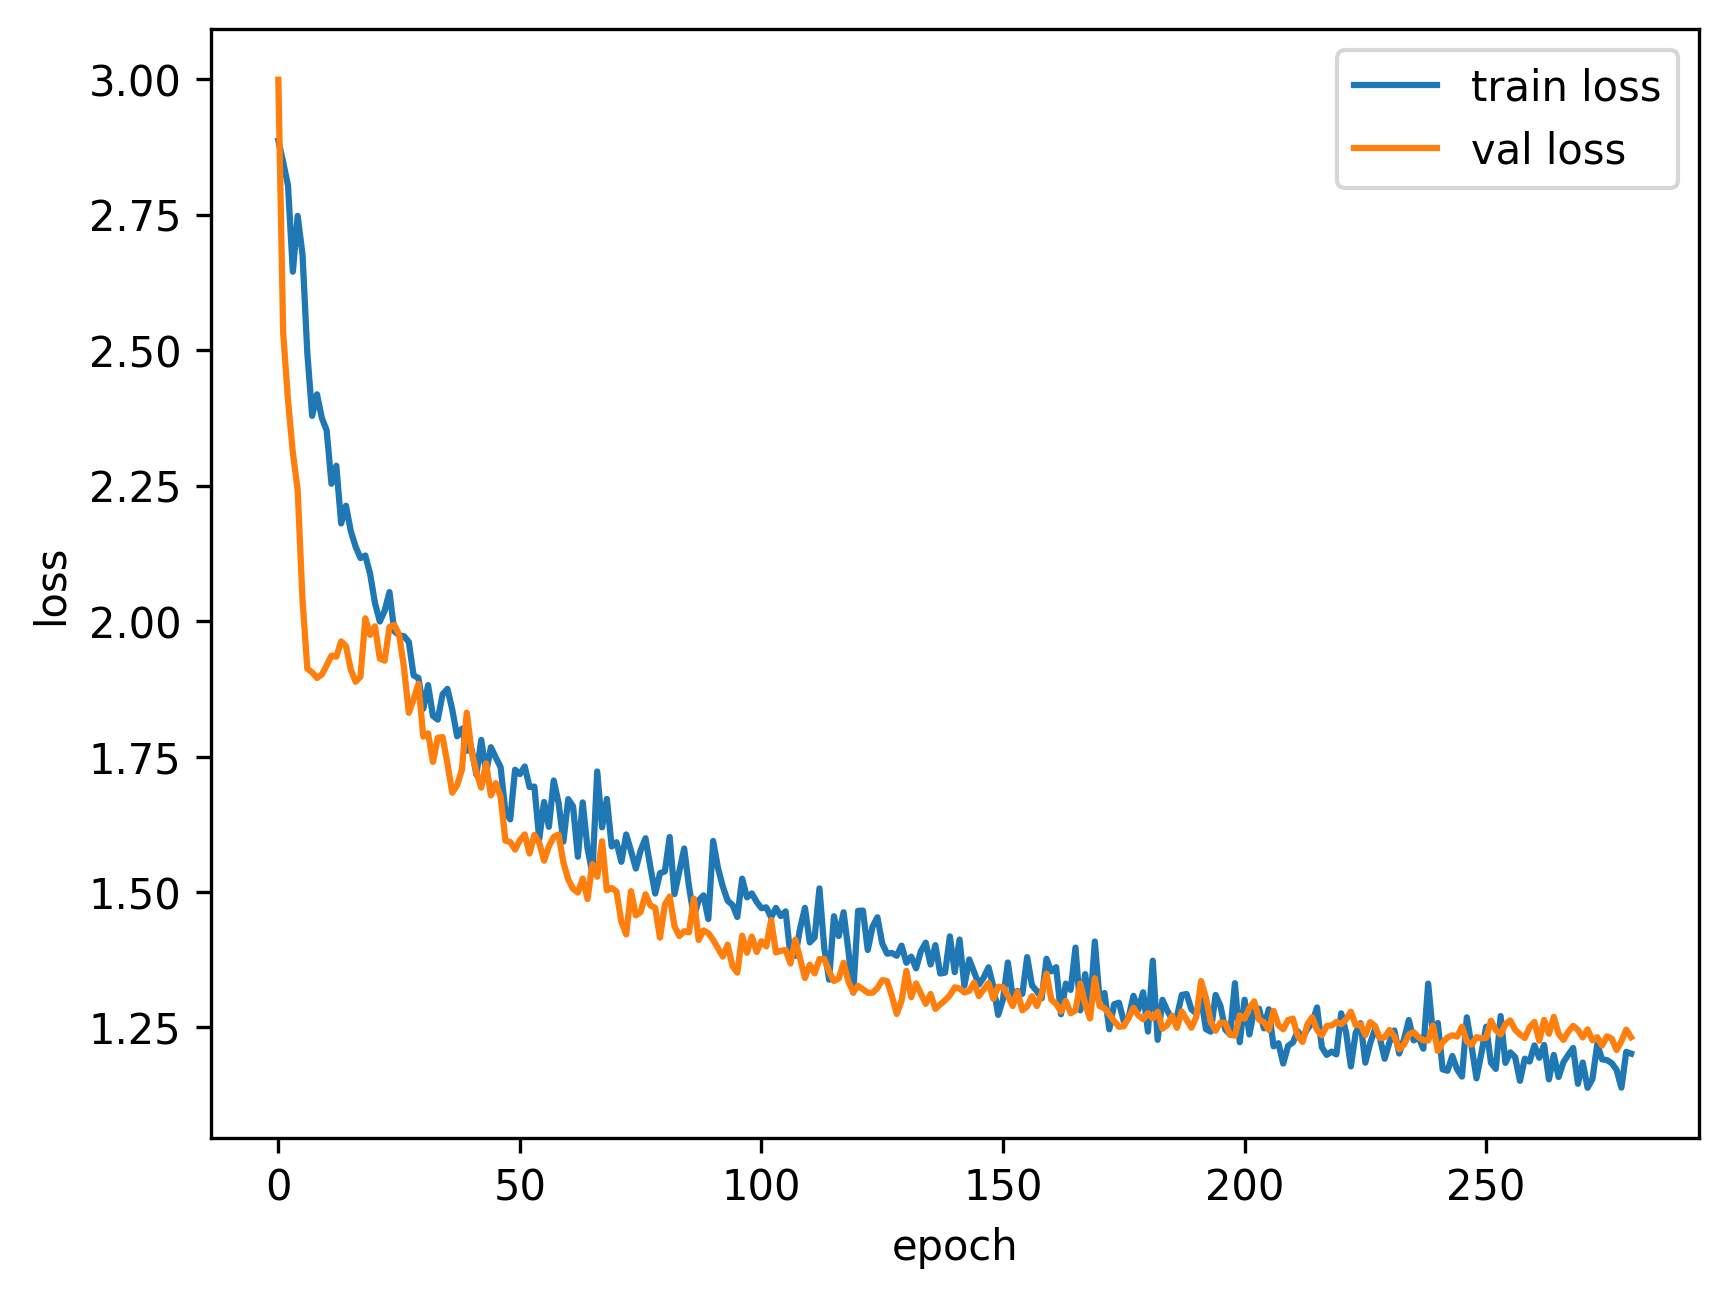

Best validation loss: 1.2067232384131505
epoch for best validation loss: 240


In [11]:
# best quality for plots
plt.rcParams['figure.dpi'] = 300

losses = pd.read_csv('losses.csv')
train_losses = losses['train_loss']
val_losses = losses['val_loss']

plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
# set x-axis label
plt.xlabel('epoch')
# set y-axis label
plt.ylabel('loss')
plt.legend()
plt.show()

print("Best validation loss:", best_val_loss)
print("epoch for best validation loss:", np.argmin(val_losses))

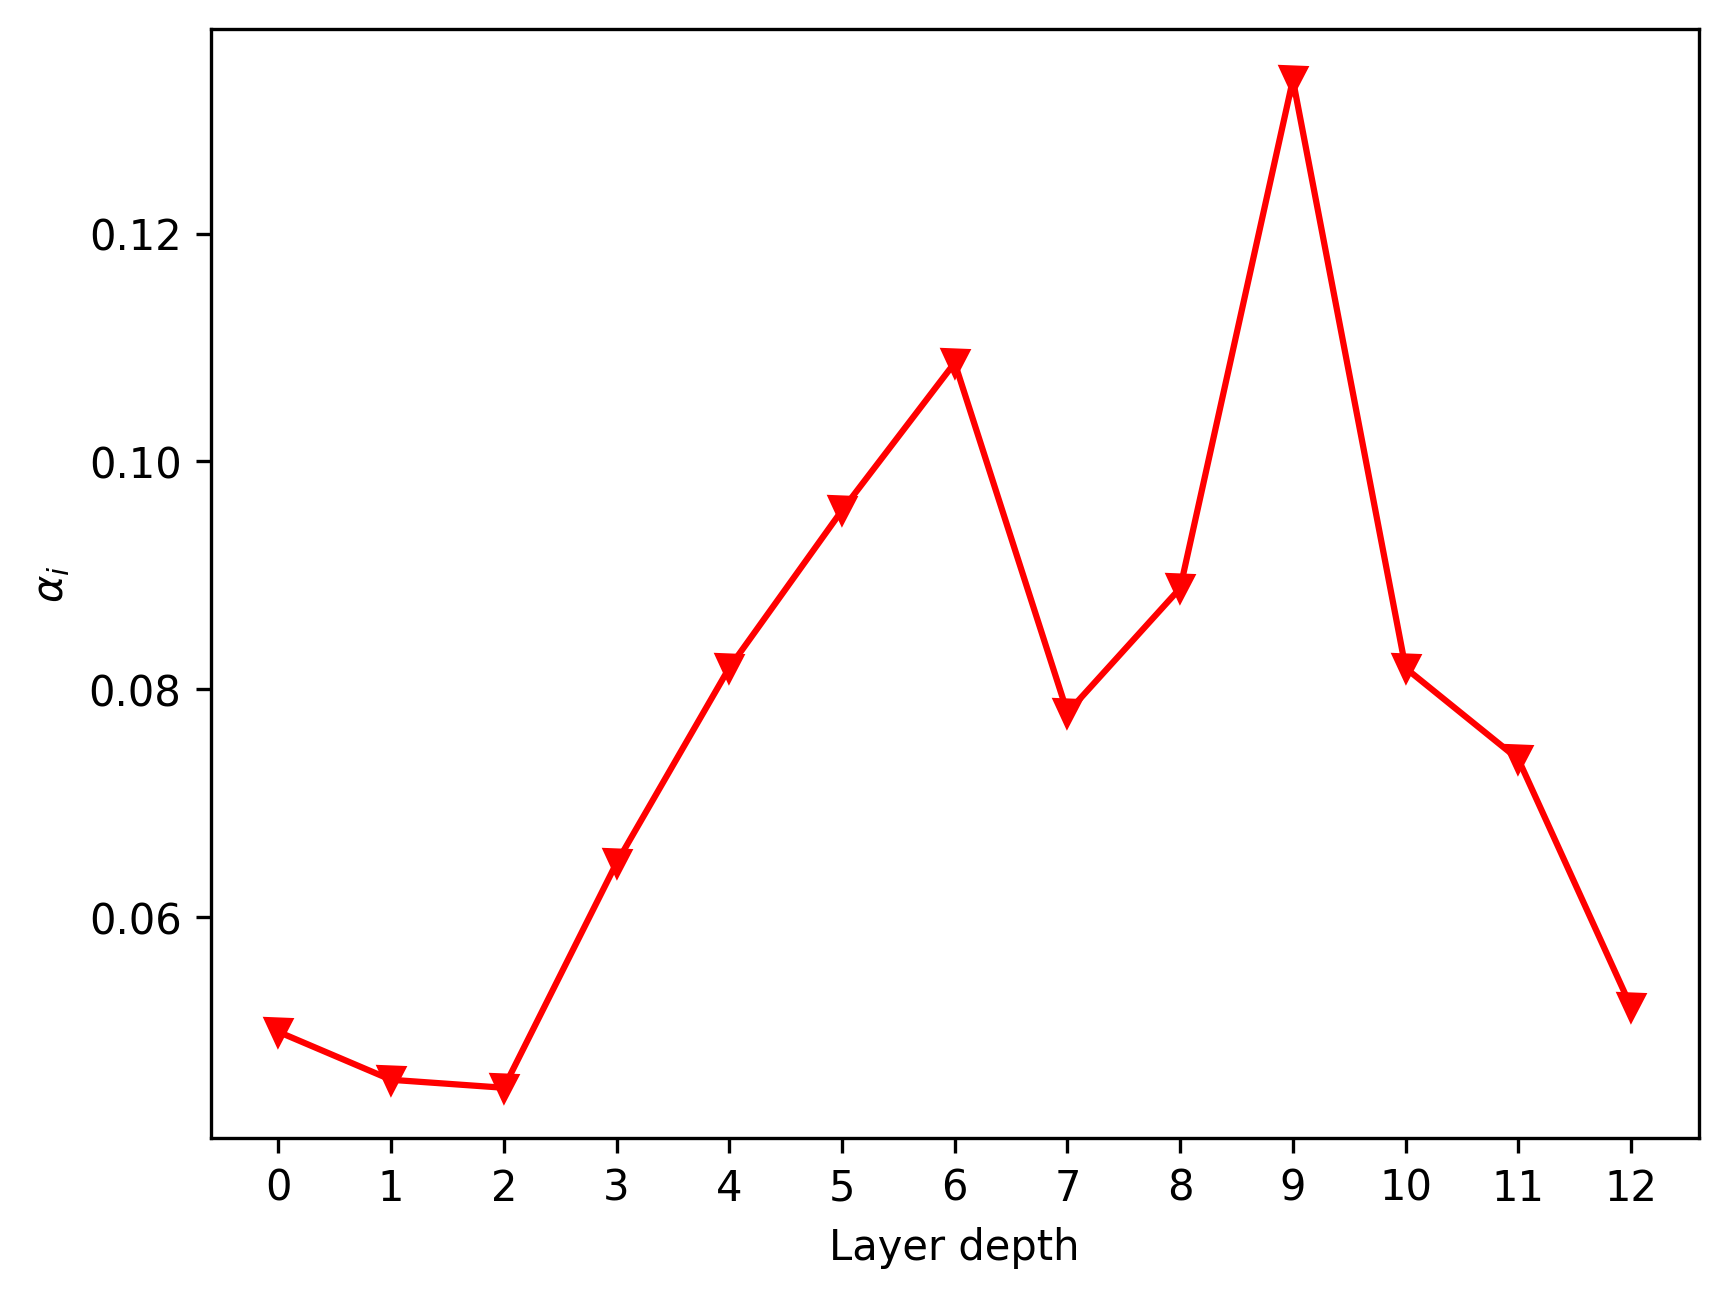

In [13]:
# plot the torch.nn.functional.softmax(dense_mos.weighted_average.weights, dim=0)
# aka the layer number and its importance
softmax_weights = torch.nn.functional.softmax(dense_mos.weighted_average.weights, dim=0).detach().cpu().numpy()

#save the weights to a csv
weights = pd.DataFrame({'softmax_weights': softmax_weights})
weights.to_csv('softmax_weights.csv', index=False)

plt.plot(softmax_weights, marker='v', linestyle='-', color='red', alpha=1, label='Softmax Weights')
plt.xlabel('Layer depth')
plt.xticks(range(13))
# y label is alpha character, the greek letter, with a subindice 
plt.ylabel(r'$\alpha_i$')
plt.show()

# Evaluation and Testing

In [22]:
# Create the testing DataLoader
test_csv_path = "/home/aleph/tesis/classifier/test_shuffled.csv"
test_dataset = MOSDataset(test_csv_path, split='test')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load the best model
best_model_path = "/home/aleph/tesis/classifier/DenseMOS_tests/best_model.pth"
dense_mos = DenseMOS(input_dim=768, hidden_dim=128, dropout_prob=0.6, num_layers=13)  # Ensure correct model initialization
dense_mos.to(device)  # Move the model to the device
dense_mos.load_state_dict(torch.load(best_model_path))  # Load the saved models
dense_mos.eval()  # Set model to evaluation mode

# Evaluate the model on the test set
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # DataLoader for testing
test_loss = 0.0
outputs_list = []
targets_list = []
with torch.no_grad():  # No gradients needed during evaluation
    for inputs, targets in test_loader:
        inputs = inputs.to(device)  # Move inputs to the GPU
        targets = targets.to(device)  # Move targets to the GPU
        outputs = dense_mos(inputs)  # Forward pass
        outputs_list.append(outputs)
        targets_list.append(targets)
        loss = loss_fn(outputs, targets)  # Calculate loss
        test_loss += loss.item()  # Accumulate the loss

# Average test loss over all batches
avg_test_loss = test_loss / len(test_loader)
print("Test Loss:", avg_test_loss)  # Evaluate the model's performance on the test set

# Convert targets and outputs to NumPy arrays
targets = np.squeeze(torch.cat(targets_list).cpu().numpy())
outputs = np.squeeze(torch.cat(outputs_list).cpu().numpy())


Test Loss: 1.1534428367247949


In [23]:
# calculate pearson's correlation coefficient and targets_array, compute mae, mse, rmse and r2
# between the predicted MOS scores and the ground truth MOS scores, aka the targets and outputs

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

# Calculate Pearson's correlation coefficient
pearson_corr = pearsonr(targets, outputs)
print("Pearson's Correlation Coefficient:", pearson_corr[0])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(targets, outputs)
print("Mean Absolute Error (MAE):", mae)
rmse = mean_squared_error(targets, outputs, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)
r2 = r2_score(targets, outputs)
print("R^2 Score:", r2)

# calculate the mean error
mean_error = np.mean(targets - outputs)
print("Mean Error:", mean_error)


Pearson's Correlation Coefficient: 0.6102436092790912
Mean Absolute Error (MAE): 0.8237054
Root Mean Squared Error (RMSE): 1.0771801
R^2 Score: 0.2942680145222297
Mean Error: 0.21508501


/home/aleph/tesis/.env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [25]:
# print target and outputs side by side
# for i in range(200):
#     print(f"Target: {targets[i]:.2f}, Output: {outputs[i]:.2f}")
# print outputs that are above 5
for i in range(len(outputs)):
    if outputs[i] > 5:
        print(f"Target: {targets[i]:.2f}, Output: {outputs[i]:.2f}")
        # print stimuli name
        print(test_dataset.data.iloc[i]['stimuli'])

In [51]:
# combine targets and outputs into a dataframe
results = pd.read_csv("test_results.csv")
# clip values between 1 and 5
results['output'] = results['output'].clip(1, 5)
results
# results

,target,output
0,2.0,1.553135
1,2.0,2.007082
2,3.0,2.103801
3,1.0,1.196341
4,3.0,2.990961
...,...,...
387,1.0,1.000000
388,4.0,5.000000
389,3.0,1.689933
390,3.0,1.335288


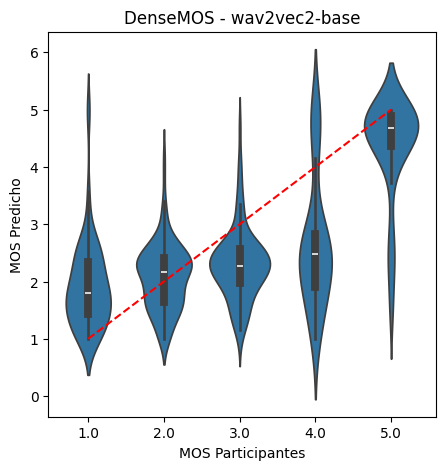

In [53]:
# violin plot of the targets and outputs
import seaborn as sns
import matplotlib.pyplot as plt


# now, lets plot the same data but with seaborn using a violin plot
fig, ax = plt.subplots(figsize=(5, 5))
sns.violinplot(x=results["target"], y=results["output"])
ax.set_title('DenseMOS - wav2vec2-base')
ax.set_xlabel('MOS Participantes')
ax.set_ylabel('MOS Predicho')
ax.plot([0, 4], [1, 5], 'r--')
plt.show()
